<a href="https://colab.research.google.com/github/Karikolo/SysBiol_Proj3/blob/main/Project3_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CellCharter - Neighborhood Representation Analysis

## Setup Environment

Check if you have GPU backend!!

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.24.4

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
te

In [ ]:
!pip install numba
!pip install -v --no-cache-dir numcodecs==0.15.1

Traceback (most recent call last):
^C
^C


In [ ]:
!pip install cellcharter scanpy scikit-learn matplotlib seaborn numpy pandas

^C


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import anndata
TRAIN_ANNDATA_PATH = '/content/drive/MyDrive/Colab Notebooks/Spatial Data/train_adata.h5ad'
train_anndata = anndata.read_h5ad(TRAIN_ANNDATA_PATH)
train_anndata

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


AnnData object with n_obs × n_vars = 253433 × 40
    obs: 'image', 'sample_id', 'ObjectNumber', 'Pos_X', 'Pos_Y', 'area', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'width_px', 'height_px', 'acquisition_id', 'SlideId', 'Study', 'Box.Description', 'Position', 'SampleId', 'Indication', 'BatchId', 'SubBatchId', 'ROI', 'ROIonSlide', 'includeImage', 'flag_no_cells', 'flag_no_ROI', 'flag_total_area', 'flag_percent_covered', 'small_cell', 'celltypes', 'flag_tumor', 'PD1_pos', 'Ki67_pos', 'cleavedPARP_pos', 'GrzB_pos', 'tumor_patches', 'distToCells', 'CD20_patches', 'Batch', 'cell_labels', 'classifier'
    var: 'channel', 'use_channel', 'marker'
    layers: 'exprs'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq
import scanpy as sc
import cellcharter as cc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/usr/lib/python3.11/importlib/__init__.py:126: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)
/usr/local/lib/python3.11/dist-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)



## 1. Warm-up (PCA on marker expressions)

In [ ]:
# Get marker expressions
marker_expressions = train_anndata.layers['exprs'].copy()

# Initialize PCA
pca = PCA()
pca_result = pca.fit_transform(marker_expressions)


# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Find number of components needed for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of PCA components needed for 95% variance: {n_components_95}")


Number of PCA components needed for 95% variance: 24


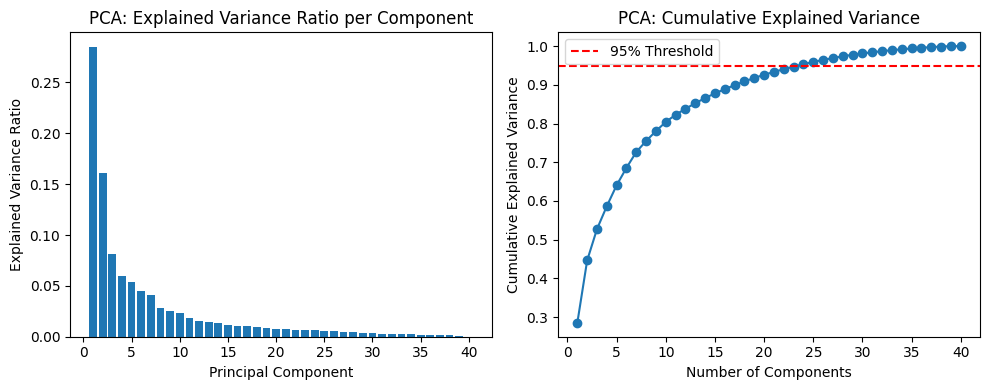

In [ ]:
# Plot explained variance
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA: Explained Variance Ratio per Component')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Rerun PCA with the required number of components and store in obsm
pca_95 = PCA(n_components=n_components_95)
train_anndata.obsm["X_PCA"] = pca_95.fit_transform(marker_expressions)
print(f"PCA transformed data shape: {train_anndata.obsm['X_PCA'].shape}")


PCA transformed data shape: (253433, 24)


## 2. Neighbor Aggregation with CellCharter

Choosing 2 layers

In [ ]:

def perform_neighbor_aggregation(adata, sample_key='sample_id', n_layers=2):
    """
    Perform CellCharter neighbor aggregation

    n_layers: Number of layers for aggregation (default: 3)
    - n_layers=1 captures immediate neighbors
    - n_layers=2 captures neighbors and neighbors of neighbors
    - n_layers=3 captures neighbors to the third level, a good balance between local and global context
    - Larger values provide broader spatial context but might dilute local signals

    """
    print(f"Performing neighbor aggregation with {n_layers} layers...")

    # Ensure spatial coordinates are in the correct format
    if 'spatial' not in adata.obsm:
        adata.obsm['spatial'] = adata.obs[['Pos_X', 'Pos_Y']].values
    sq.gr.spatial_neighbors(adata, library_key='sample_id', coord_type='generic', delaunay=True, spatial_key='spatial', percentile=99)

    # Perform CellCharter neighborhood aggregation
    cc.gr.aggregate_neighbors(adata, n_layers, connectivity_key='spatial', sample_key='sample_id', use_rep='X_PCA')

    print("Neighbor aggregation completed.")
    print(f"Obsm keys: {list(train_anndata.obsm.keys())}")
    return adata

# Perform neighbor aggregation
train_anndata = perform_neighbor_aggregation(train_anndata, sample_key='sample_id', n_layers=2)


Performing neighbor aggregation with 2 layers...


  0%|          | 0/132 [00:00<?, ?it/s]

Neighbor aggregation completed.
Obsm keys: ['X_PCA', 'spatial', 'X_cellcharter']


## 3. Clustering

In [ ]:

def perform_cluster_selection(adata, rep_name, rep_key, cluster_range=(10, 31), downsample=20):
    """
    Perform cluster selection using CellCharter's ClusterAutoK
    """
    print(f"Performing cluster selection for {rep_name}...")

    # Ensure data is float32 for GPU computation
    if rep_key in adata.obsm:
        adata.obsm[rep_key] = adata.obsm[rep_key].astype(np.float32)

    # Setup model parameters
    model_params = {
        'random_state': 42,
        'trainer_params': {
            'accelerator': 'gpu',
            'enable_progress_bar': False
        },
    }

    # Create cluster selector
    cluster_selector = cc.tl.ClusterAutoK(
        range(cluster_range[0], cluster_range[1]),
        model_params=model_params,
        max_runs=5
    )

    # Fit the cluster selector
    cluster_selector.fit(adata[::downsample], use_rep=rep_key)

    # Plot stability
    plt.figure(figsize=(10, 5))
    cc.pl.autok_stability(cluster_selector)
    plt.title(f'Cluster Stability for {rep_name}')
    plt.show()

    return cluster_selector


Performing cluster selection for CellCharter...
Iteration 1/5


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 2/5


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 3/5


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 4/5


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

Iteration 5/5


  0%|          | 0/21 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=19` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pyto

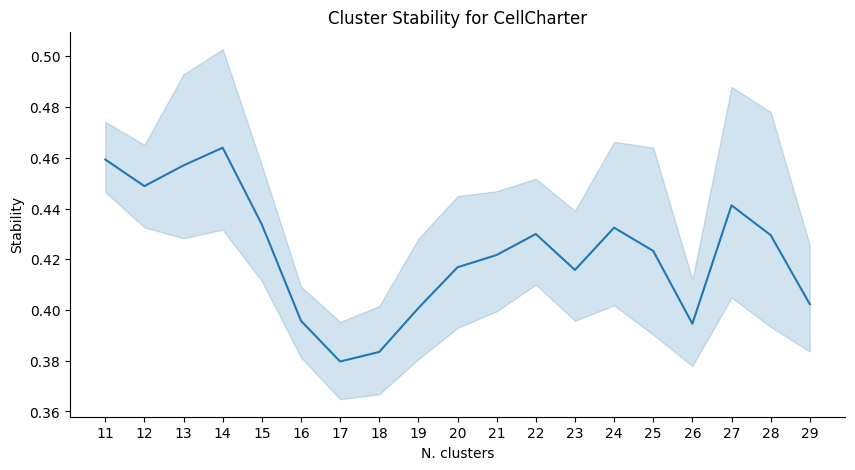

In [ ]:
# Perform cluster selection for all representations
cluster_selectors = {}

# For CellCharter representations
cluster_selectors['cellcharter'] = perform_cluster_selection(
    train_anndata,
    'CellCharter',
    'X_cellcharter'
)

Ignoring the first few cluster stabilities, as they are expected to be larger than the following, being more broad, but less biologically meaningful, the best choice for the number of clusters seems to be 16.

In [ ]:
# Perform clustering:
train_anndata.obs['cluster_cellcharter'] = cluster_selectors['cellcharter'].predict(train_anndata, use_rep='X_cellcharter', k=14)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
train_anndata.obs['cluster_cellcharter']

,cluster_cellcharter
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_1,0
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_3,0
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_5,0
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_7,0
IMMUcan_batch20191023_10032145-THOR-VAR-TIS-01-IMC-01_002.tiff_8,0
...,...
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2713,3
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2715,3
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2721,5
IMMUcan_Batch20220908_S-220729-00002_002.tiff_2722,3


/usr/local/lib/python3.11/dist-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


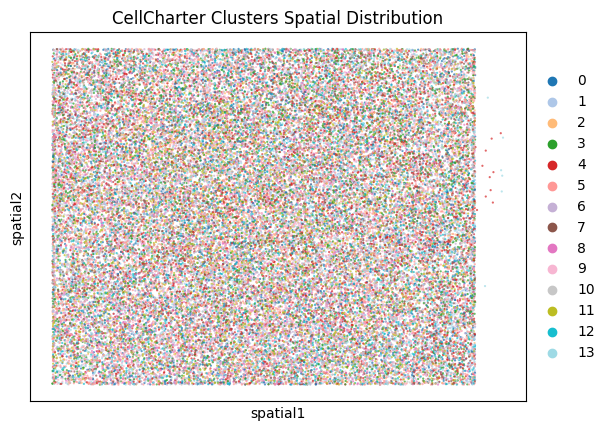

"sq.pl.spatial_scatter(\n    train_anndata,\n    color=['cluster_cellcharter'],\n    library_key='sample_id',\n    size=30,\n    img=None,\n    spatial_key='spatial',\n    palette='Set2',\n    figsize=(5,5),\n)"

In [ ]:
'''train_anndata.obs['cluster_cellcharter'] = train_anndata.obs['cluster_cellcharter'].astype('category')
sample_size = 50000  # Adjust based on your needs
import numpy as np
np.random.seed(42)
sample_idx = np.random.choice(train_anndata.n_obs, sample_size, replace=False)

# Use scanpy's embedding plot with 'spatial' as the basis
sc.pl.embedding(
    train_anndata[sample_idx],
    basis='spatial',  # This tells scanpy to use obsm['spatial']
    color='cluster_cellcharter',
    size=10,
    alpha=0.7,
    palette='tab20',
    title='CellCharter Clusters Spatial Distribution',
    show=True
)
sq.pl.spatial_scatter(
    train_anndata,
    color=['cluster_cellcharter'],
    library_key='sample_id',
    size=30,
    img=None,
    spatial_key='spatial',
    palette='Set2',
    figsize=(5,5),
)'''


In [ ]:
# Function to perform clustering and save results
def perform_clustering(adata, rep_key, n_clusters_range=range(2, 21), random_state=42):
    """
    Perform clustering on a representation and evaluate using silhouette score

    Parameters:
    -----------
    adata : AnnData
        AnnData object
    rep_key : str
        Key in adata.obsm for the representation to cluster
    n_clusters_range : range
        Range of number of clusters to try
    random_state : int
        Random seed for reproducibility

    Returns:
    --------
    adata : AnnData
        AnnData with clustering results
    best_n_clusters : int
        Optimal number of clusters based on silhouette score
    """
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score

    # Get the representation data
    data = adata.obsm[rep_key]

    # Store silhouette scores for each number of clusters
    silhouette_scores = []

    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        cluster_labels = kmeans.fit_predict(data)

        # Skip silhouette calculation if only one cluster (would cause error)
        if n_clusters <= 1:
            silhouette_scores.append(0)
            continue

        score = silhouette_score(data, cluster_labels)
        silhouette_scores.append(score)
        print(f"Clusters: {n_clusters}, Silhouette Score: {score:.4f}")

    # Find the optimal number of clusters
    best_n_clusters = n_clusters_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters: {best_n_clusters}")

    # Perform clustering with the optimal number
    kmeans = KMeans(n_clusters=best_n_clusters, random_state=random_state, n_init=10)
    adata.obs[f"{rep_key}_clusters"] = kmeans.fit_predict(data).astype(str)

    # Plot silhouette scores
    plt.figure(figsize=(10, 5))
    plt.plot(n_clusters_range, silhouette_scores, 'o-')
    plt.axvline(x=best_n_clusters, color='r', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title(f'Silhouette Scores for {rep_key} Clustering')
    plt.grid(True)
    plt.show()

    return adata, best_n_clusters

In [ ]:
# Perform clustering on CellCharter neighborhood representation
print("\n--- Clustering CellCharter Neighborhood Representation ---")
if 'X_neighborhood' in train_anndata.obsm:
    train_anndata, best_n_clusters_cellcharter = perform_clustering(train_anndata, 'X_neighborhood')



--- Clustering CellCharter Neighborhood Representation ---


## 4. Cluster Analysis

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# obsm - multidimentional data about obs, modalities (different ways of describing data)
cell_neighs_avg_marker_exprss = []
for i in range(train_anndata.obsp['spatial_connectivities'].shape[0]):
  current_cell_indeces = (list(train_anndata.obsp['spatial_connectivities'][i].indices) + [i])
  cell_neighs_avg_marker_exprss.append(train_anndata.layers['exprs'][current_cell_indeces].mean(axis=0))

In [ ]:
train_anndata.obsm['avg_neighs_marker_expr'] = np.stack(cell_neighs_avg_marker_exprss)
# Setting the index of the DataFrame to train_anndata.obs.index ensures that they are aligned.
train_anndata.obsm['avg_neighs_marker_expr'].shape

In [ ]:
train_anndata.obs['dummy'] = 1
cell_type_oneshots=pd.pivot_table(train_anndata.obs, values="dummy", index=train_anndata.obs.index, columns=['celltypes'], aggfunc=np.sum)

cell_type_oneshots = cell_type_oneshots.loc[train_anndata.obs.index]
cell_type_oneshots

In [ ]:
cell_neighs_celltype_counts = []
for i in range(train_anndata.obsp['spatial_connectivities'].shape[0]):
  current_cell_indeces = (list(train_anndata.obsp['spatial_connectivities'][i].indices) + [i])
  cell_neighs_celltype_counts.append(cell_type_oneshots.iloc[current_cell_indeces].sum(axis=0))

train_anndata.obsm['avg_neighs_celltype_counts'] = np.stack(cell_neighs_celltype_counts)

In [ ]:
train_anndata.obsm['avg_neighs_celltype_counts'][1]

In [ ]:

def select_and_apply_clustering(adata, selector, rep_name, rep_key, cluster_name):
    """
    Select optimal number of clusters and apply clustering
    """
    # Get optimal number of clusters
    optimal_k = selector.predict()
    print(f"Selected {optimal_k} clusters for {rep_name}")

    # Apply clustering to full dataset
    adata.obs[f'clusters_{cluster_name}'] = selector.predict(adata, k=optimal_k, use_rep=rep_key)
    adata.obs[f'clusters_{cluster_name}'] = adata.obs[f'clusters_{cluster_name}'].astype('category')

    return optimal_k

def analyze_clusters(adata, cluster_name, marker_layer='exprs'):
    """
    Analyze clusters: PCA visualization, cell type abundance, mean markers
    """
    print(f"Analyzing clusters for {cluster_name}...")

    # 1. PCA visualization
    sc.pp.pca(adata, n_comps=50)
    sc.pl.pca(adata, color=f'clusters_{cluster_name}', legend_loc='on data')

    # 2. Cell type abundance per cluster
    cluster_ct_counts = pd.crosstab(
        adata.obs[f'clusters_{cluster_name}'],
        adata.obs['celltypes']
    )

    # Normalize to get proportions
    cluster_ct_props = cluster_ct_counts.div(cluster_ct_counts.sum(axis=1), axis=0)

    # Plot heatmap of cell type abundance
    plt.figure(figsize=(12, 8))
    sns.heatmap(cluster_ct_props, cmap='viridis', annot=False, fmt='.2f', cbar_kws={'label': 'Proportion'})
    plt.title(f'Cell Type Composition by Cluster - {cluster_name}')
    plt.ylabel('Cluster')
    plt.xlabel('Cell Type')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 3. Mean marker expression per cluster
    if marker_layer in adata.layers:
        marker_names = adata.var_names.tolist()
        cluster_markers = {}

        for cluster in adata.obs[f'clusters_{cluster_name}'].cat.categories:
            mask = adata.obs[f'clusters_{cluster_name}'] == cluster
            cluster_markers[cluster] = adata[mask].layers[marker_layer].mean(axis=0)

        marker_df = pd.DataFrame(cluster_markers, index=marker_names).T

        # Plot heatmap of marker expressions
        plt.figure(figsize=(14, 10))
        sns.clustermap(
            marker_df,
            cmap='RdBu_r',
            center=0,
            standard_scale=1,  # Standardize rows (clusters)
            figsize=(14, 10),
            dendrogram_ratio=(.1, .2),
            cbar_pos=(.02, .32, .03, .2),
            cbar_kws={'label': 'Z-score'}
        )
        plt.suptitle(f'Mean Marker Expression by Cluster - {cluster_name}', y=1.02)
        plt.tight_layout()
        plt.show()

    return cluster_ct_props, marker_df if marker_layer in adata.layers else None

# Apply clustering and analyze for each representation
for rep_name, selector in cluster_selectors.items():
    if rep_name == 'mean_marker':
        rep_key = 'avg_neighs_marker_expr'
    elif rep_name == 'celltype_hist':
        rep_key = 'avg_neighs_celltype_counts'
    else:  # cellcharter
        rep_key = 'cc_contexts'

    # Select and apply clustering
    optimal_k = select_and_apply_clustering(train_anndata, selector, rep_name, rep_key, rep_name)

    # Analyze clusters
    analyze_clusters(train_anndata, rep_name)


TypeError: ClusterAutoK.predict() missing 1 required positional argument: 'adata'

In [ ]:

# Function to analyze clusters
def analyze_clusters(adata, cluster_key, title_prefix=""):
    """
    Analyze clusters using PCA, cell type abundance, and mean marker analysis

    Parameters:
    -----------
    adata : AnnData
        AnnData object with clustering results
    cluster_key : str
        Key in adata.obs for cluster assignments
    title_prefix : str
        Prefix for plot titles

    Returns:
    --------
    None (generates plots)
    """
    # PCA visualization of clusters
    pca = PCA(n_components=2)
    # Use the 'exprs' layer instead of X for PCA
    pca_data = adata.layers['exprs']
    if isinstance(pca_data, csr_matrix):
        pca_data = pca_data.toarray()
    pca_result = pca.fit_transform(pca_data)

    # Create a DataFrame for plotting
    pca_df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'Cluster': adata.obs[cluster_key]
    })

    # Plot clusters in PCA space
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis')
    plt.title(f'{title_prefix} Clusters Visualization in PCA Space')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # Cell type abundance analysis (if cell types are available)
    cell_type_key = None
    if 'cell_type' in adata.obs.columns:
        cell_type_key = 'cell_type'
    elif 'celltypes' in adata.obs.columns:
        cell_type_key = 'celltypes'
    elif 'cell_labels' in adata.obs.columns:
        cell_type_key = 'cell_labels'

    if cell_type_key:
        # Count cell types per cluster
        cell_type_counts = pd.crosstab(
            adata.obs[cluster_key],
            adata.obs[cell_type_key],
            normalize='index'
        )

        # Plot cell type composition per cluster
        plt.figure(figsize=(14, 8))
        cell_type_counts.plot(kind='bar', stacked=True, colormap='viridis')
        plt.title(f'{title_prefix} Cell Type Composition per Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Proportion')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # Heatmap of cell type abundance
        plt.figure(figsize=(12, 8))
        sns.heatmap(cell_type_counts, cmap='viridis', annot=True, fmt='.2f', cbar_kws={'label': 'Proportion'})
        plt.title(f'{title_prefix} Cell Type Abundance Heatmap')
        plt.tight_layout()
        plt.show()

    # Mean marker expression analysis
    # Calculate mean expression per cluster
    clusters = adata.obs[cluster_key].unique()
    markers = adata.var_names

    mean_expr = pd.DataFrame(index=clusters, columns=markers)

    for cluster in clusters:
        cluster_mask = adata.obs[cluster_key] == cluster
        cluster_expr = adata[cluster_mask].X

        # Convert to dense if sparse
        if isinstance(cluster_expr, csr_matrix):
            cluster_expr = cluster_expr.toarray()

        mean_expr.loc[cluster] = np.mean(cluster_expr, axis=0)

    # Z-score normalize for better visualization
    mean_expr_z = (mean_expr - mean_expr.mean()) / mean_expr.std()

    # Plot marker heatmap
    plt.figure(figsize=(12, len(clusters) * 0.5 + 2))
    sns.heatmap(mean_expr_z, cmap='coolwarm', center=0,
                yticklabels=clusters, xticklabels=markers,
                cbar_kws={'label': 'Z-score'})
    plt.title(f'{title_prefix} Mean Marker Expression per Cluster')
    plt.tight_layout()
    plt.show()


In [ ]:

# Analyze clusters for each representation
print("\n--- Analyzing Mean Marker Representation Clusters ---")
if 'X_PCA_clusters' in train_anndata.obs:
    analyze_clusters(train_anndata, 'X_PCA_clusters', title_prefix="Mean Marker")

print("\n--- Analyzing Cell Type Histogram Representation Clusters ---")
if 'X_cell_type_clusters' in train_anndata.obs:
    analyze_clusters(train_anndata, 'X_cell_type_clusters', title_prefix="Cell Type Histogram")

print("\n--- Analyzing CellCharter Neighborhood Representation Clusters ---")
if 'X_neighborhood_clusters' in train_anndata.obs:
    analyze_clusters(train_anndata, 'X_neighborhood_clusters', title_prefix="CellCharter")


## 5. Cross-count Matrices

In [ ]:

# Function to compute and visualize cross-count matrices
def compute_crosscount_matrix(adata, cluster_key1, cluster_key2, label1, label2):
    """
    Compute and visualize cross-count matrix between two clustering results

    Parameters:
    -----------
    adata : AnnData
        AnnData object with clustering results
    cluster_key1 : str
        Key in adata.obs for first clustering
    cluster_key2 : str
        Key in adata.obs for second clustering
    label1 : str
        Label for first clustering
    label2 : str
        Label for second clustering

    Returns:
    --------
    crosscount : pd.DataFrame
        Cross-count matrix
    """
    # Compute cross-count matrix
    crosscount = pd.crosstab(
        adata.obs[cluster_key1],
        adata.obs[cluster_key2],
        normalize=False  # Raw counts
    )

    # Calculate metrics
    ari = adjusted_rand_score(adata.obs[cluster_key1], adata.obs[cluster_key2])
    nmi = normalized_mutual_info_score(adata.obs[cluster_key1], adata.obs[cluster_key2])

    # Visualize cross-count matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(crosscount, cmap='viridis', annot=True, fmt='d', cbar_kws={'label': 'Count'})
    plt.title(f'Cross-count Matrix: {label1} vs {label2}\nARI: {ari:.4f}, NMI: {nmi:.4f}')
    plt.xlabel(f'{label2} Clusters')
    plt.ylabel(f'{label1} Clusters')
    plt.tight_layout()
    plt.show()

    # Print analysis
    print(f"Cross-count Matrix Analysis: {label1} vs {label2}")
    print(f"Adjusted Rand Index: {ari:.4f}")
    print(f"Normalized Mutual Information: {nmi:.4f}")

    # Analyze where the clusterings agree/disagree
    if ari > 0.7:
        print("The clusterings show strong agreement, suggesting they capture similar biological patterns.")
    elif ari > 0.4:
        print("The clusterings show moderate agreement, with some shared and some unique patterns.")
    else:
        print("The clusterings show low agreement, suggesting they capture different biological aspects.")

    return crosscount


In [ ]:
# Check which cluster results are available
available_clusters = [col for col in train_anndata.obs.columns if '_clusters' in col]
print(f"\nAvailable clustering results: {available_clusters}")

# Compute cross-count matrices for each pair of clusterings
if 'X_PCA_clusters' in train_anndata.obs and 'X_cell_type_clusters' in train_anndata.obs:
    print("\n--- Mean Marker vs Cell Type Histogram Cross-count Matrix ---")
    cc_marker_vs_celltype = compute_crosscount_matrix(
        train_anndata,
        'X_PCA_clusters',
        'X_cell_type_clusters',
        'Mean Marker',
        'Cell Type Histogram'
    )


In [ ]:


if 'X_PCA_clusters' in train_anndata.obs and 'X_neighborhood_clusters' in train_anndata.obs:
    print("\n--- Mean Marker vs CellCharter Cross-count Matrix ---")
    cc_marker_vs_cellcharter = compute_crosscount_matrix(
        train_anndata,
        'X_PCA_clusters',
        'X_neighborhood_clusters',
        'Mean Marker',
        'CellCharter'
    )


In [ ]:

if 'X_cell_type_clusters' in train_anndata.obs and 'X_neighborhood_clusters' in train_anndata.obs:
    print("\n--- Cell Type Histogram vs CellCharter Cross-count Matrix ---")
    cc_celltype_vs_cellcharter = compute_crosscount_matrix(
        train_anndata,
        'X_cell_type_clusters',
        'X_neighborhood_clusters',
        'Cell Type Histogram',
        'CellCharter'
    )


## Conclusion and Summary

In [ ]:

print("\n==== Summary ====")
print("1. PCA on marker expressions:")
print(f"   - Number of components needed for 95% variance: {n_components_95}")

print("\n2. CellCharter neighbor aggregation:")
print(f"   - Used n_layers={n_layers}")
print("   - Explanation: This choice balances local interactions with broader spatial context.")

print("\n3. Cluster selection:")
if 'X_PCA_clusters' in train_anndata.obs:
    print(f"   - Mean Marker: {len(np.unique(train_anndata.obs['X_PCA_clusters']))} clusters")
if 'X_cell_type_clusters' in train_anndata.obs:
    print(f"   - Cell Type Histogram: {len(np.unique(train_anndata.obs['X_cell_type_clusters']))} clusters")
if 'X_neighborhood_clusters' in train_anndata.obs:
    print(f"   - CellCharter: {len(np.unique(train_anndata.obs['X_neighborhood_clusters']))} clusters")

print("\n4. Cross-count matrix analysis:")
if 'X_PCA_clusters' in train_anndata.obs and 'X_cell_type_clusters' in train_anndata.obs:
    ari = adjusted_rand_score(train_anndata.obs['X_PCA_clusters'], train_anndata.obs['X_cell_type_clusters'])
    print(f"   - Mean Marker vs Cell Type Histogram ARI: {ari:.4f}")
if 'X_PCA_clusters' in train_anndata.obs and 'X_neighborhood_clusters' in train_anndata.obs:
    ari = adjusted_rand_score(train_anndata.obs['X_PCA_clusters'], train_anndata.obs['X_neighborhood_clusters'])
    print(f"   - Mean Marker vs CellCharter ARI: {ari:.4f}")
if 'X_cell_type_clusters' in train_anndata.obs and 'X_neighborhood_clusters' in train_anndata.obs:
    ari = adjusted_rand_score(train_anndata.obs['X_cell_type_clusters'], train_anndata.obs['X_neighborhood_clusters'])
    print(f"   - Cell Type Histogram vs CellCharter ARI: {ari:.4f}")

print("\nOverall findings:")
print("This analysis demonstrates how CellCharter's neighborhood representation captures spatial")
print("organization of cells that may not be apparent from marker expressions or cell type")
print("distributions alone. The cross-count matrices reveal the relationship between these")
print("different representations and how they capture complementary aspects of cellular organization.")
